# Topological Assignment Improved

The idea of this mapper is **to map at the beginning the first n-most-used-qubits** (which will be put in the middle of the circuit) and then run the TopologicalAssignment mapper as it is.

In [1]:
from copy import copy
from queue import PriorityQueue

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout, CouplingMap
from qiskit.circuit.library import SwapGate

from qiskit.transpiler import TranspilerError
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock.backends import FakeBrooklyn
import random, os, csv

from qiskit.converters import circuit_to_dag
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import dag_to_circuit

from tabulate import tabulate

from utils.BasicSwap import BasicSwap
from utils.SwapModified import BasicSwapModified
from utils.TopologicalAssignment import TopologicalAssignment
from utils.cost import *

In [2]:
"""
return an ordered list of the most involved qubits in two-qubits operation
"""
def most_involved(dag):
    q = {}
    for layer in dag.serial_layers():
        subdag = layer['graph']
        
        for gate in subdag.two_qubit_ops():
            q0 = gate.qargs[0]
            q1 = gate.qargs[1]
            
            if q0 in q:
                q[q0] += 1
            else:
                q[q0] = 1
            if q1 in q:
                q[q1] += 1
            else:
                q[q1] = 1
                
    q_list = sorted(q, key=q.get, reverse=True)
    return q_list

In [3]:
# Topological Assignment Improved

"""
Given the coupling map of a real device and a dag circuit, 
create a layout (map physical qubits to logical) that permits
to have less costs when a basic pass is used

"""

class TopologicalAssignmentImproved():
    
    def __init__(self,
                 coupling_map):
        
        self.coupling_map = coupling_map
        self.num_qubits = 65
        
    def run(self, dag,n_most_used):
               
        # create an empty dictionary from a 65 qubit device         
        canonical_register = dag.qregs['q']
        trivial_layout = Layout.generate_trivial_layout(canonical_register)
                
        # initialize layout dictionary
        # keys --> virtual, values --> physical
        # layout_dict[virtual_qbit] to access the physical
        # list(layout_dict.values()) to retrieve the physical qubits used
        layout_dict = trivial_layout.copy().get_virtual_bits() 
        
        # initialize the dictionary such that each virtual qubits is not assigned
        # to any physical qubit
        for virtual in layout_dict.keys():
            layout_dict[virtual] = None
                
        # i: arbitrary starting qubit
        # the ideal is to start mapping the qubits from qubits 
        # which are located in the center of the circuit 
        # (see coupling_map drawing above)
        i = 31
        
        # ---- improvement ----
        # assign the n_most_used logical qubits to the central physical qubits 
        # (usually the most connected)
        most_used_qubits = most_involved(dag)
        for n in range(n_most_used):
            layout_dict[most_used_qubits[n]] = i
            i += 1
        
        ###
        assignments = []
        ###
        
        # walk through the dag searching for two-qubits operations
        for layer in dag.serial_layers():
            subdag = layer['graph']
            for gate in subdag.two_qubit_ops():

                physical_q0 = layout_dict[gate.qargs[0]]
                physical_q1 = layout_dict[gate.qargs[1]]
                switched = 0

                ###
                a = False
                b = False
                if physical_q0 == None:
                    a = True
                if physical_q1 == None:
                    b = True
                ###
                # gate defines a two qubits op with virtual qubits gate.qargs[0] and gate.qargs[1]
                if physical_q0 == None: #physical qubit not associated yet
                    if physical_q1 == None:
                        layout_dict[gate.qargs[0]] = i
                        physical_q0 = i
                    else:
                        physical_q0 = layout_dict[gate.qargs[1]] 
                        physical_q1 = layout_dict[gate.qargs[0]]
                        switched = 1  # keep track that now physical_q0 contains virtual_q1
 
                # physical_q0 is now assigned
                if physical_q1 == None: #physical qubit not associated yet
                    assigned = False                    
                    distance_q0 = self.coupling_map.distance_matrix[physical_q0].copy()
                    physical_assigned = [x for x in layout_dict.values() if x is not None]
                    
                    # starting from qubits with distance 1, take all the qubits that 
                    # have that distance from physical_q0 (candidates): if one of them is not assigned yet,
                    # assign it, otherwise increase the distance allowed
                    for j in range(1, int(distance_q0.max()) + 1):  #let j as close as possible to physical_q0
                        candidates = [index for index, element in enumerate(distance_q0) if element == j] #element is the distance from q0
                        random.shuffle(candidates)
                        
                        for n in candidates: #search in the nearest qubits wrt q0
                            if n not in physical_assigned:
                                layout_dict[gate.qargs[1 - switched]] = n
                                physical_q1 = n
                                assigned = True
                                break
                        if assigned == True:
                            break
                            
                    # physical_q1 should be assigned
                    if assigned == False:
                        raise TranspilerError('The layout does not match the amount of qubits in the DAG')                    
                    
                physical_assigned =  [x for x in layout_dict.values() if x is not None] 
                if len(physical_assigned) == self.num_qubits: # the mapping is completed
                    break
                    
                while i in physical_assigned:  #let i as close as possible to the previous qubits
                    i += 1
                    if i == 65:
                        i = 0
                        
                ###
                if a is True:
                    assignments.append(physical_q0 if not switched else physical_q1)
                    a = False
                if b is True:
                    assignments.append(physical_q1 if not switched else physical_q0)
                    b = False
                ###
                
        #print('\n-->This is how physical qubits have been assigned by the algorithm (in order):\n', assignments)
                
        physical = [x for x in layout_dict.values() if x is not None]
        #print('\n\nNum of physical unique qubit assigned (without unused qubits): --',len(physical), ' out of ', len(layout_dict.keys()))

        # map all the unused qubits
        used = [x for x in layout_dict.values() if x is not None]
        total = list(range(0, self.num_qubits))
        unused = [x for x in total if x not in used]  
        
        for virtual in layout_dict.keys():
            if layout_dict[virtual] == None:
                layout_dict[virtual] = unused[0]
                unused.pop(0)
        
        #check        
        physical = set(layout_dict.values())
        #print('\nNum of physical unique qubit assigned (with used qubits): --',len(physical), ' out of ', len(layout_dict.keys()))
        
        layout = Layout(layout_dict)
        return layout

In [4]:
# info device 65 qubits -- create DAG with 65 qubits
backend = FakeBrooklyn()
num_qubits =  backend.configuration().n_qubits
coupling_list = backend.configuration().coupling_map
coupling_map = CouplingMap(couplinglist=coupling_list)
device_qc = QuantumCircuit(num_qubits, num_qubits)
device_DAG = circuit_to_dag(device_qc) 

# info input circuit n <= 65 qubits -- create DAG with n qubits
file_name = 'adder-3'
input_path = './original/' + file_name + '.qasm'
qc = QuantumCircuit.from_qasm_file(path=input_path)
input_DAG = circuit_to_dag(qc) 

# build the input_DAG (n qubits) on the device_DAG (65 qubits)
# now device_DAG has 65 qubits with the structure of the input_DAG
device_DAG.compose(input_DAG)


In [5]:
# create and run the mapper: a mapping (layout) is returned
tp = TopologicalAssignmentImproved(coupling_map)
tp_layout = tp.run(device_DAG, 1)
print('\n--------------Mapping-------------\n---Physical qubit : Virtual qubit---\n', tp_layout)


--------------Mapping-------------
---Physical qubit : Virtual qubit---
 Layout({
45: Qubit(QuantumRegister(65, 'q'), 0),
29: Qubit(QuantumRegister(65, 'q'), 1),
32: Qubit(QuantumRegister(65, 'q'), 2),
39: Qubit(QuantumRegister(65, 'q'), 3),
30: Qubit(QuantumRegister(65, 'q'), 4),
31: Qubit(QuantumRegister(65, 'q'), 5),
0: Qubit(QuantumRegister(65, 'q'), 6),
1: Qubit(QuantumRegister(65, 'q'), 7),
2: Qubit(QuantumRegister(65, 'q'), 8),
3: Qubit(QuantumRegister(65, 'q'), 9),
4: Qubit(QuantumRegister(65, 'q'), 10),
5: Qubit(QuantumRegister(65, 'q'), 11),
6: Qubit(QuantumRegister(65, 'q'), 12),
7: Qubit(QuantumRegister(65, 'q'), 13),
8: Qubit(QuantumRegister(65, 'q'), 14),
9: Qubit(QuantumRegister(65, 'q'), 15),
10: Qubit(QuantumRegister(65, 'q'), 16),
11: Qubit(QuantumRegister(65, 'q'), 17),
12: Qubit(QuantumRegister(65, 'q'), 18),
13: Qubit(QuantumRegister(65, 'q'), 19),
14: Qubit(QuantumRegister(65, 'q'), 20),
15: Qubit(QuantumRegister(65, 'q'), 21),
16: Qubit(QuantumRegister(65, 'q'),

### Now you have the layout 
so you can use it as input of the Basic pass. n.b. You must use the modified version of the basic pass that doesn't build another trivial layout but uses the layout given as parameter.

Define costs functions for different mappers

In [6]:
# return a list of costs with the following mappers: 
# basic_swap, lv3, topological_assignment, topological_assignment_improved
def compute_costs(qc):
    # create a circuit the same size as the device, in terms of qubits and clbits
    qc1 = qc.copy()
    device_qc_1 = QuantumCircuit(num_qubits, num_qubits)
    device_DAG_1 = circuit_to_dag(device_qc_1) 
    initial_layout_1 = Layout.generate_trivial_layout(*device_DAG_1.qregs.values())
    input_DAG_1 = circuit_to_dag(qc1) 
    
    # build the input_DAG on the device_DAG (65 qubits)
    device_DAG_1.compose(input_DAG_1)
    
    # for basic pass
    basic_pass = BasicSwap(coupling_map, initial_layout_1)
    new_dag_basic_pass = basic_pass.run(device_DAG_1)
    cost_basic_pass = compute_cost(new_dag_basic_pass)
    print('basic pass - ok \n')
    
    # for traspiler lv3
    new_circ_lv3 = transpile(qc1, backend=backend, optimization_level=3)
    new_dag_lv3 = circuit_to_dag(new_circ_lv3)
    cost3 = compute_cost(new_dag_lv3)
    print('transpiler pass lv3 - ok \n')
    
    # for topological assignment
    qc2 = qc.copy()
    new_input_DAG2 = circuit_to_dag(qc2) 
    
    # build the input_DAG on the device_DAG (65 qubits)
    new_device_qc2 = QuantumCircuit(num_qubits, num_qubits)
    new_device_DAG2 = circuit_to_dag(new_device_qc2) 
    new_device_DAG2.compose(new_input_DAG2)
    
    tp = TopologicalAssignment(coupling_map)
    tp_layout = tp.run(new_device_DAG2)
    basic_pass_modified = BasicSwapModified(coupling_map, tp_layout)
    new_dag_tp_assignment = basic_pass_modified.run(new_device_DAG2)
    cost_tp_assignment = compute_cost(new_dag_tp_assignment)
    print('tp assignment - ok \n')
    
    return [cost_basic_pass, cost3, cost_tp_assignment]

In [7]:
def compute_cost_tp_improved(qc, n_most_used):
    # for topological assignment improved - take n most used qubit
    total_cost = []
    for n in range(n_most_used):
        qc_copy = qc.copy()
        new_input_DAG = circuit_to_dag(qc_copy) 

        # build the input_DAG on the device_DAG (65 qubits)
        new_device_qc = QuantumCircuit(num_qubits, num_qubits)
        new_device_DAG = circuit_to_dag(new_device_qc) 
        new_device_DAG.compose(new_input_DAG)

        tpi = TopologicalAssignmentImproved(coupling_map)
        tp_layouti = tpi.run(new_device_DAG, n + 1) # n is from 0 to (n_most_used - 1)
        basic_pass_modifiedi = BasicSwapModified(coupling_map, tp_layouti)
        new_dag_tp_assignmnet_i = basic_pass_modifiedi.run(new_device_DAG)
        cost_tp_assignment_i = compute_cost(new_dag_tp_assignmnet_i)
        total_cost.append(cost_tp_assignment_i)
        print('tp assignment improved - ',n + 1, ' most used qubit - ok \n')

    return total_cost

**Run** the mappers with different inputs

In [31]:
folderpath = r".\original" # make sure to put the 'r' in front
filepaths  = [os.path.join(folderpath, name) for name in os.listdir(folderpath)]
table_rows = []

# for this project we just analyse up to 5 most used qubits
n_most_used = 5

for i in range(5):
#for i in range(len(filepaths)):
    print('------------iteration ', i, '-----------  file: ', filepaths[i], '----------')
    input_path3 = filepaths[i]
    qc3 = QuantumCircuit.from_qasm_file(path=input_path3)
    costs = compute_costs(qc3)
    costs += compute_cost_tp_improved(qc3, n_most_used)
    print('tot------', costs)
    row = [input_path3.rsplit('\\', 1)[1]]
    row.extend(costs)
    table_rows.append(row)  

------------iteration  0 -----------  file:  .\original\adder-13.qasm ----------
gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 494, 'swap': 874, 'barrier': 1, 'measure': 26}


Cost of the circuit: 31186
basic pass - ok 

gates---
 {'rz': 813, 'rx': 0, 'sx': 240, 'cx': 1512, 'swap': 0, 'x': 33, 'barrier': 1, 'measure': 26}


Cost of the circuit: 15360
transpiler pass lv3 - ok 

gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 494, 'swap': 732, 'barrier': 1, 'measure': 26}


Cost of the circuit: 26926
tp assignment - ok 

gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 494, 'swap': 714, 'barrier': 1, 'measure': 26}


Cost of the circuit: 26386
tp assignment improved -  1  most used qubit - ok 

gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 494, 'swap': 791, 'barrier': 1, 'measure': 26}


Cost of the circuit: 28696
tp assignment improved -  2  most used qubit - ok 

gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 494, 'swap': 770, 'barrier': 1, 'measure': 26}


Cost of the circuit: 28066
tp

In [32]:
table = [['benchmark name', 'basic swap', 'lv=3', 'tp assignment', 'tpi_1', 'tpi_2', 'tpi_3', 'tpi_4', 'tpi_5']]
table.extend(table_rows)

print('--------------------------- Cost in terms of gates-------------------------------------------------------')
print(tabulate(table,headers='firstrow', tablefmt='fancy_grid', numalign='center'))

--------------------------- Cost in terms of gates-------------------------------------------------------
╒═══════════════════╤══════════════╤════════╤═════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│ benchmark name    │  basic swap  │  lv=3  │  tp assignment  │  tpi_1  │  tpi_2  │  tpi_3  │  tpi_4  │  tpi_5  │
╞═══════════════════╪══════════════╪════════╪═════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│ adder-13.qasm     │    31186     │ 15360  │      26926      │  26386  │  28696  │  28066  │  25966  │  28756  │
├───────────────────┼──────────────┼────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ adder-16.qasm     │    48202     │ 18398  │      47812      │  50272  │  46012  │  46342  │  49612  │  47512  │
├───────────────────┼──────────────┼────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ adder-3.qasm      │     786      │  492   │       576       │   576   │   576   │   576   │   

### Let's see the improvements
wrt the previous version of TopologicalAssignment (*tp_assignment*).

We can see that **TopologicalAssignmentImproved with 1-most-used-qubit assigned at the beginning** (*tpi_1*) usually performs better than TopologicalAssignment without the improvement: *see red dots*.

We can also notice that **2-most-used-qubits** is usually the best wrt TopologicalAssignment mappers and sometimes using even 3 or 4 or 5-most-used-qubits lead to improvements in the terms of cost reduction: *see green dots*. 

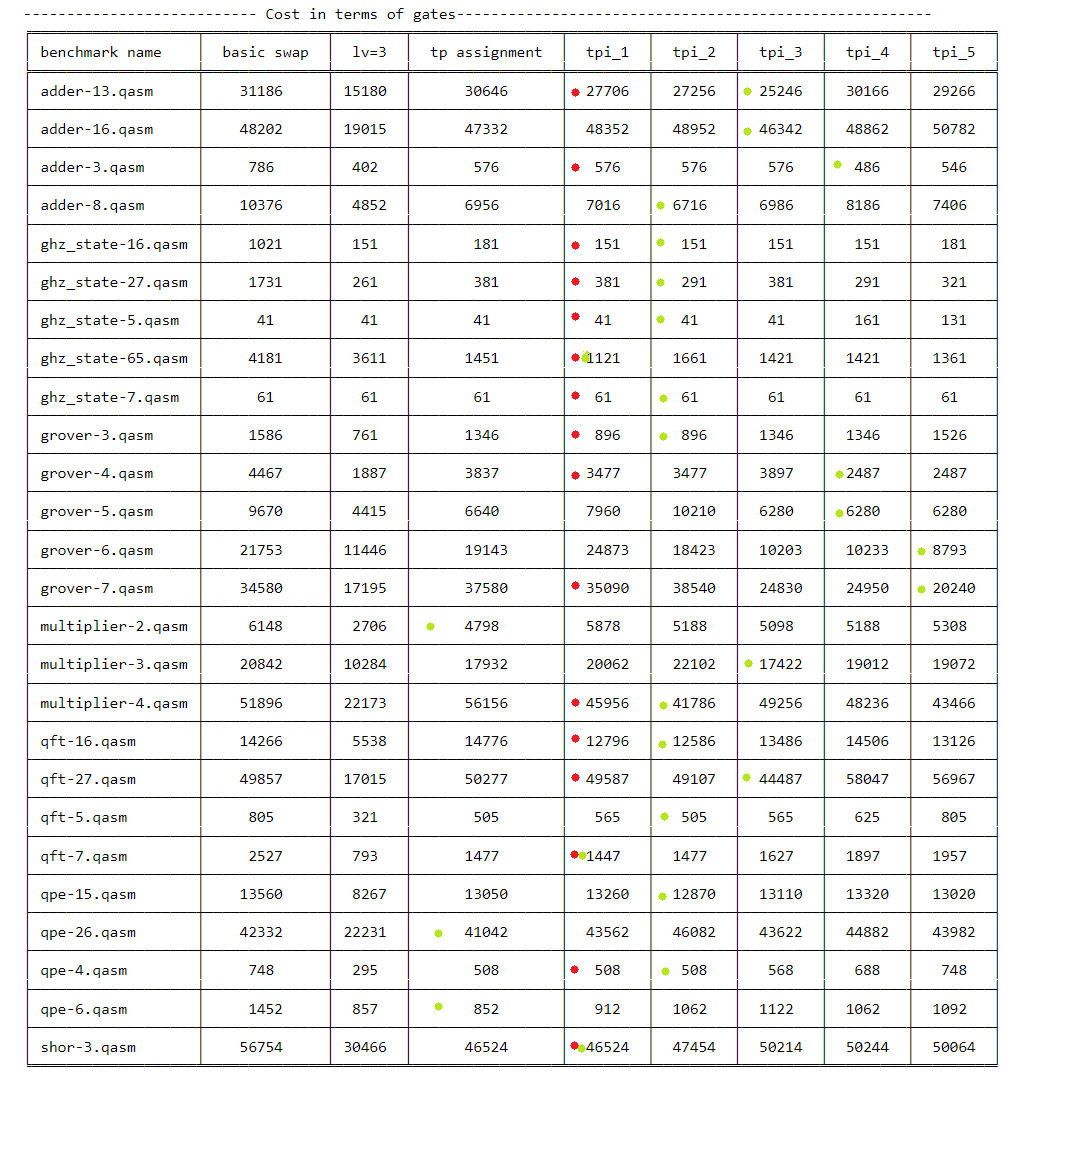

In [33]:
from IPython.display import Image
Image(filename='./output/tpi/comparison-tpi.png')

# For the task
Run the mapper and produce:
- a mapped .qasm
- a csv file with the cost of each circuit

In [56]:
def tp_mapping(qc):
    qc_copy = qc.copy()
    new_input_DAG = circuit_to_dag(qc_copy) 

    # build the input_DAG on the device_DAG (65 qubits)
    new_device_qc = QuantumCircuit(num_qubits, num_qubits)
    new_device_DAG = circuit_to_dag(new_device_qc) 
    new_device_DAG.compose(new_input_DAG)

    tpi = TopologicalAssignmentImproved(coupling_map)
    tp_layouti = tpi.run(new_device_DAG, 2) # n-most-used = 1
    basic_pass_modifiedi = BasicSwapModified(coupling_map, tp_layouti)
    new_dag_tp_assignmnet_i = basic_pass_modifiedi.run(new_device_DAG)
    new_qc = dag_to_circuit(new_dag_tp_assignmnet_i)
    cost_tp_assignment_i = compute_cost(new_dag_tp_assignmnet_i)
    
    # for the file comment
    physical_list = list(tp_layouti.get_physical_bits().keys())
    physical_str = ''
    for elem in physical_list:
        physical_str = physical_str + str(elem) + ' '
    
    return new_qc, physical_str, cost_tp_assignment_i

In [9]:
folderpath = r".\original" # make sure to put the 'r' in front
filepaths  = [os.path.join(folderpath, name) for name in os.listdir(folderpath)]
table_rows = []

# for this project we just analyse up to 5 most used qubits
n_most_used = 5

In [30]:
# open the file in the write mode
f = open("./output/csv/test.csv", 'w')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
uno = '1'
due = '2'
writer.writerow([uno + ';' + due])

# close the file
f.close()

In [12]:
print(filepaths[0].split("\\")[-1][:-5])
print(filepaths[0])

adder-13
.\original\adder-13.qasm


In [57]:
cost_list = []
#for i in range(2):
for i in range(len(filepaths)):
    print('------------iteration ', i, '-----------  file: ', filepaths[i], '----------')
    
    # input
    input_path3 = filepaths[i]
    qc3 = QuantumCircuit.from_qasm_file(path=input_path3)
    filename = filepaths[i].split("\\")[-1][:-5]

    # mapping
    qc_mapped, map_list, cost = tp_mapping(qc3)
    print('mapping -- ok')

    cost_list.append(filename + "; " + str(cost) + "\n")
    
    # output qasm
    out_qasm_path = './output/qasm/' + filename + '.qasm'
    out_comment = '// i ' + map_list + '\n\n'
    out_string = out_comment + qc_mapped.qasm()
    text_file = open(out_qasm_path, "w")
    text_file.write(out_string)
    text_file.close()
    print('qasm -- ok\n\n')
    
# output csv
out_csv_path = './output/csv/all-costs.csv'
with open(out_csv_path, "w") as csv_file:
    csv_file.write("file name; circuit cost\n" )
    for row in cost_list:
        csv_file.write(row)
print('\n\ncsv -- ok')

------------iteration  0 -----------  file:  .\original\adder-13.qasm ----------
gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 494, 'swap': 729, 'barrier': 1, 'measure': 26}


Cost of the circuit: 26836
mapping -- ok
qasm -- ok


------------iteration  1 -----------  file:  .\original\adder-16.qasm ----------
gates---
 {'rz': 801, 'rx': 0, 'sx': 32, 'cx': 752, 'swap': 1196, 'barrier': 1, 'measure': 32}


Cost of the circuit: 43432
mapping -- ok
qasm -- ok


------------iteration  2 -----------  file:  .\original\adder-3.qasm ----------
gates---
 {'rz': 34, 'rx': 0, 'sx': 6, 'cx': 24, 'swap': 11, 'barrier': 1, 'measure': 6}


Cost of the circuit: 576
mapping -- ok
qasm -- ok


------------iteration  3 -----------  file:  .\original\adder-8.qasm ----------
gates---
 {'rz': 209, 'rx': 0, 'sx': 16, 'cx': 184, 'swap': 180, 'barrier': 1, 'measure': 16}


Cost of the circuit: 7256
mapping -- ok
qasm -- ok


------------iteration  4 -----------  file:  .\original\ghz_state-16.qasm ----------
